# Crop Recommendation Model

## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import pickle
import os

## Config

In [2]:
DATA_PATH = "./dataset/Crop_recommendation.csv"
MODEL_PATH = "crop_model_pipeline.pkl"
ENCODER_PATH = "label_encoder_classes.pkl"
MLFLOW_EXPERIMENT_NAME = "Crop_Recommendation_Experiment"
SCALER_PATH = "scaler.pkl"

# Check Data set Folder
if not os.path.exists("dataset"):
    os.makedirs("dataset")
    print(f"Folder 'dataset' dibuat. Harap letakkan 'Crop_recommendation.csv' di dalamnya.")

## Load Dataset

In [3]:
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset berhasil dimuat. Ukuran: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: File {DATA_PATH} tidak ditemukan.")
    print("Pastikan Anda telah menempatkan file 'Crop_recommendation.csv' di dalam folder 'dataset'.")
    exit()

Dataset berhasil dimuat. Ukuran: (2200, 8)


## EDA

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

5 Baris Pertama Dataset:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.6048

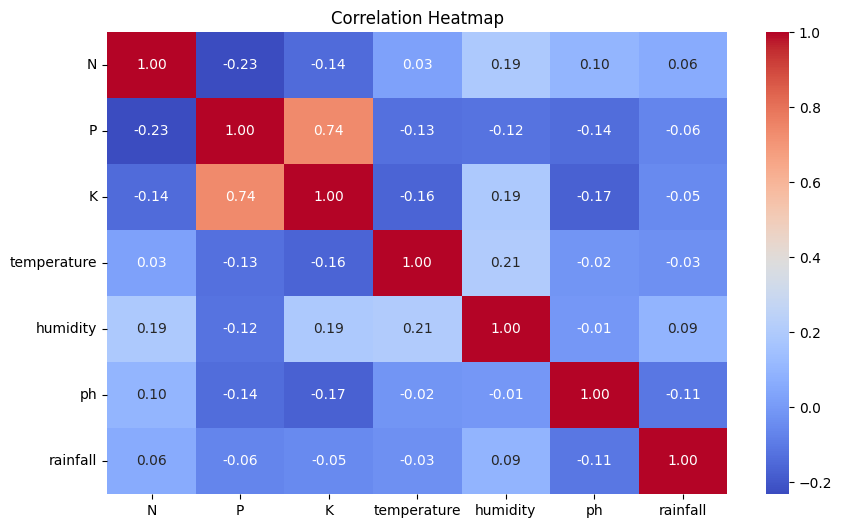

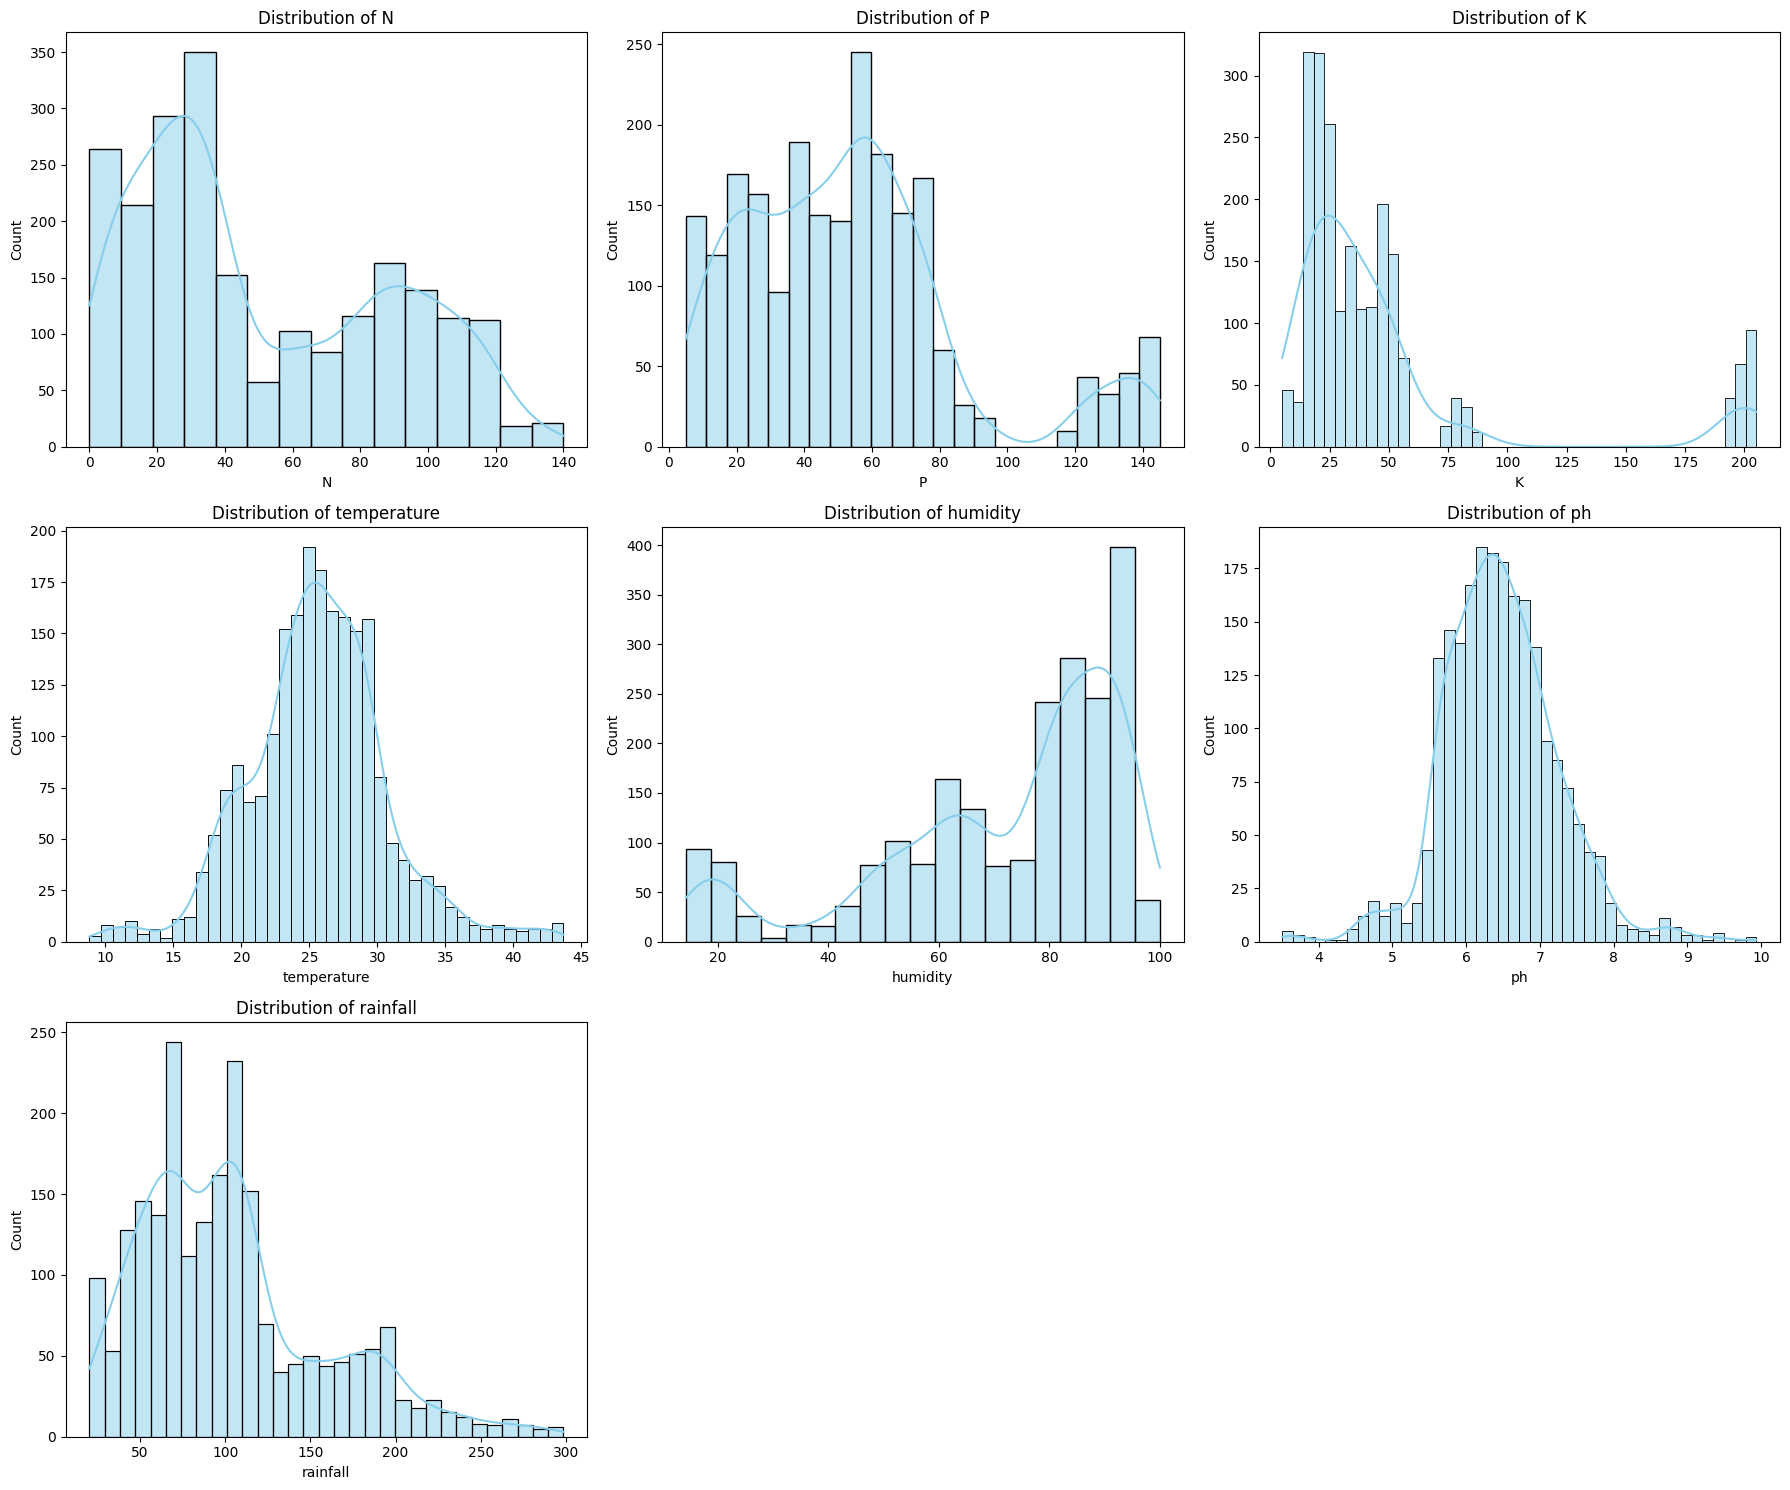

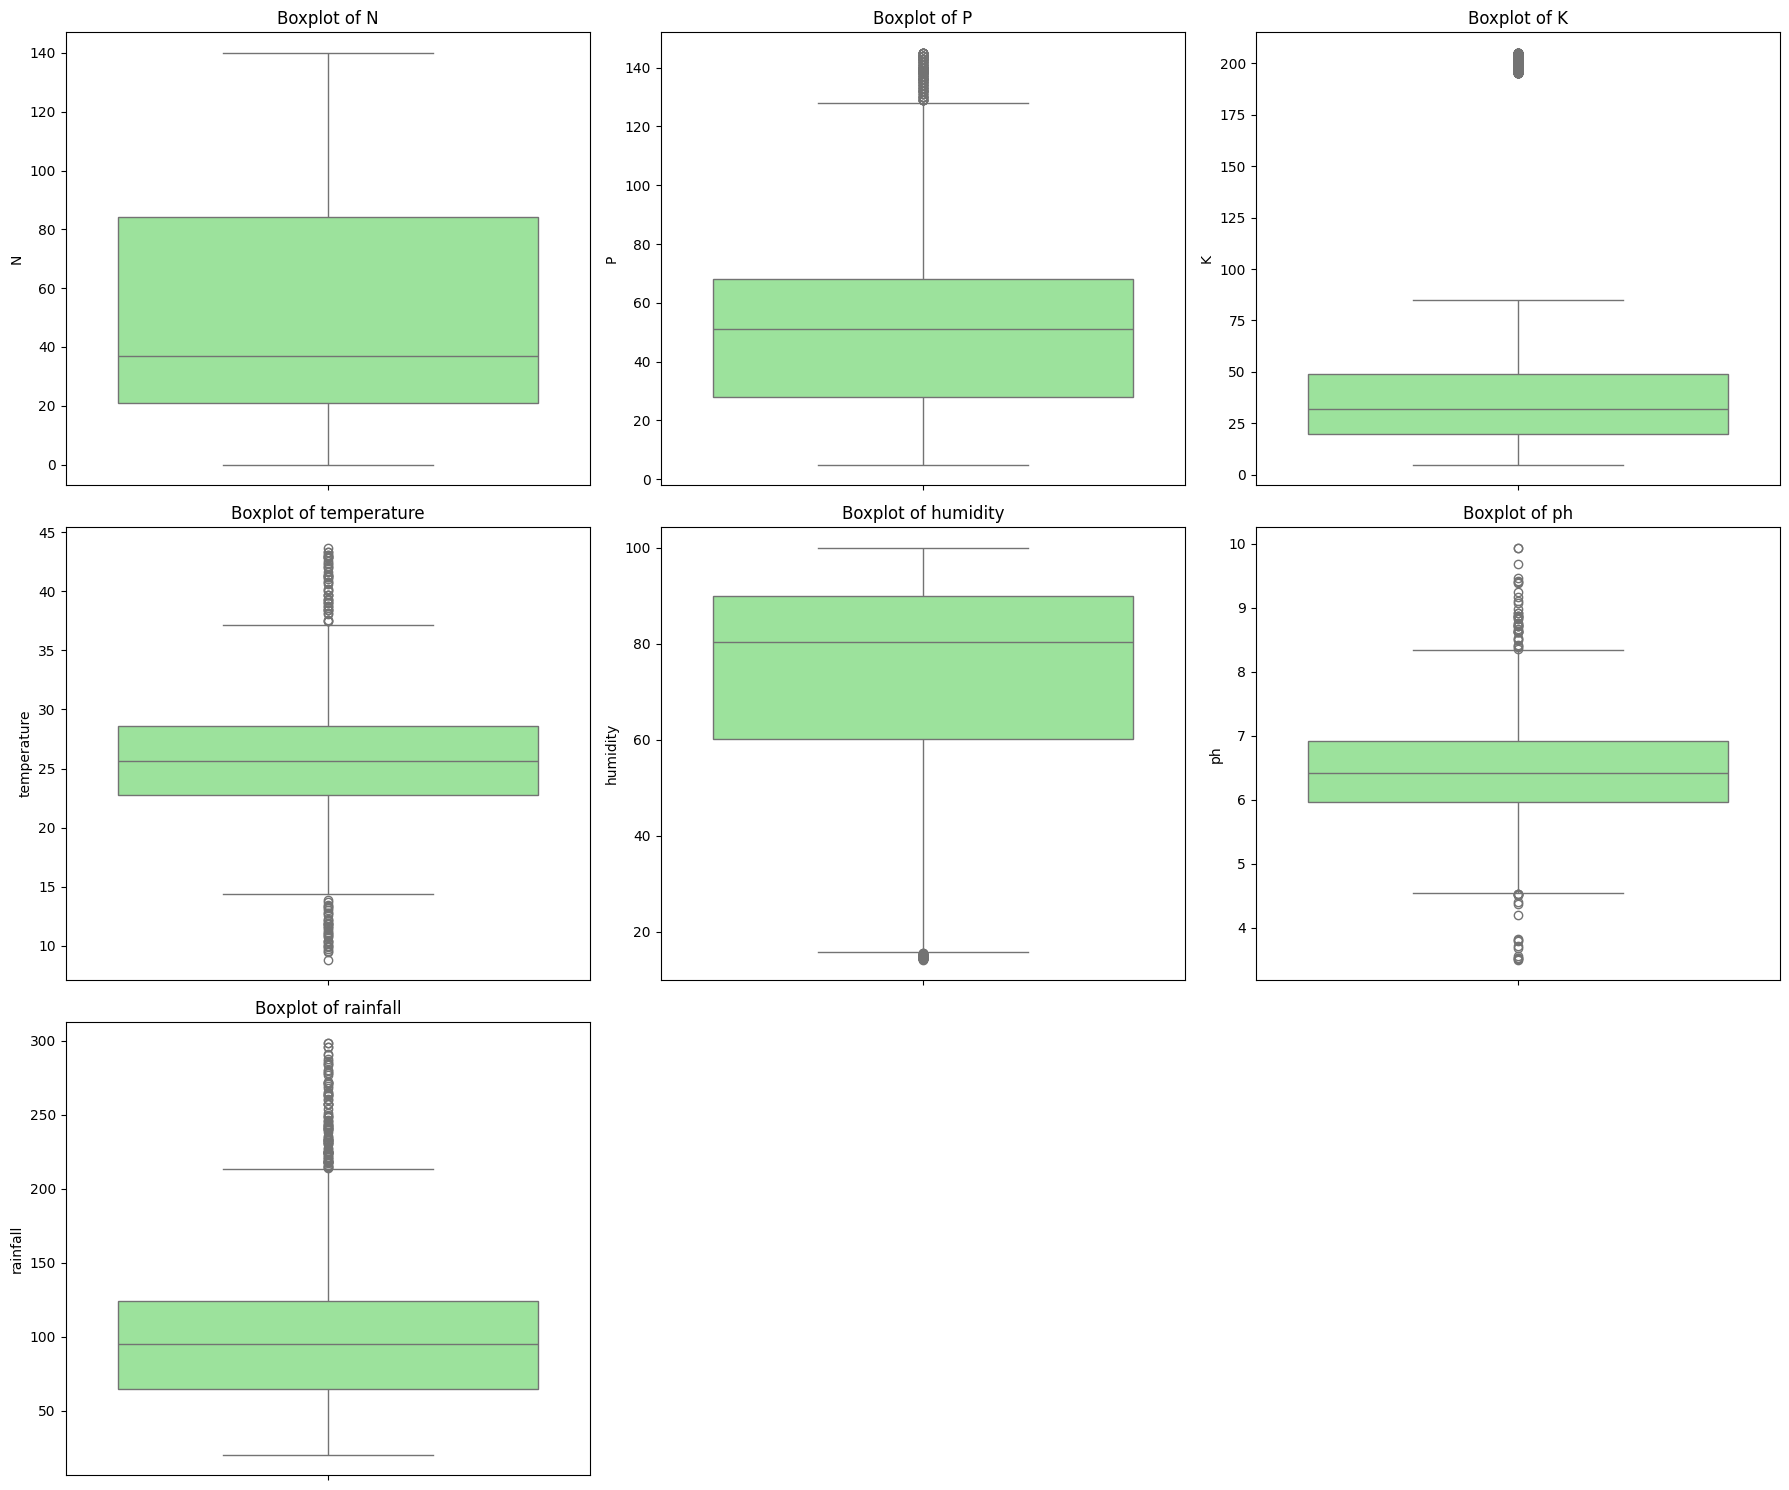

C:\Users\PIik\AppData\Local\Temp\ipykernel_44868\2733379589.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='viridis')


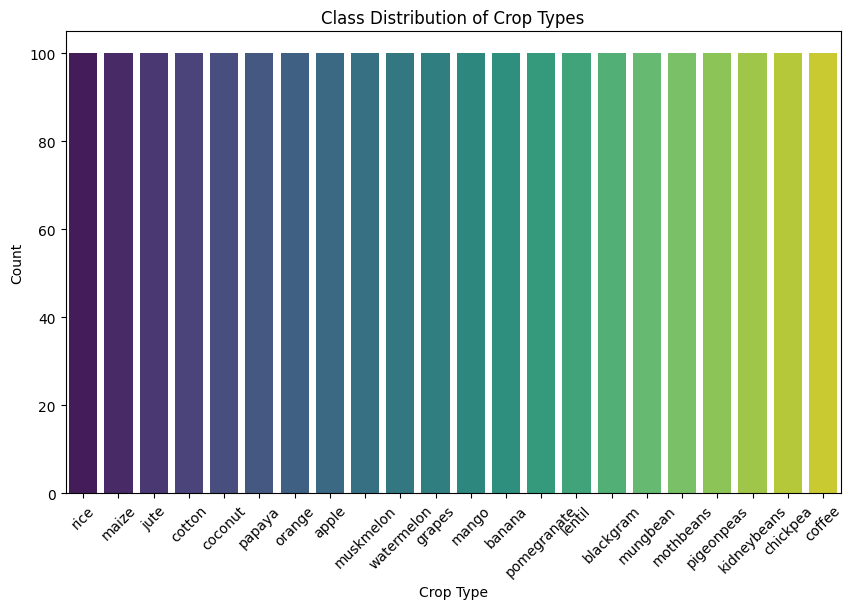

In [4]:
print("Info Dataset:")
print(df.info())

print("\n5 Baris Pertama Dataset:")
print(df.head())

print("\nCek missing values:")
print(df.isnull().sum())

# Visualisasi korelasi antar fitur numerik
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

numeric_cols = df.select_dtypes(include=np.number).columns
n = len(numeric_cols)
cols = 3
rows = int(np.ceil(n / cols))

plt.figure(figsize=(cols * 6, rows * 5))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

#  Boxplot untuk fitur numerik
plt.figure(figsize=(cols * 6, rows * 5))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='viridis')
plt.title("Class Distribution of Crop Types")
plt.xlabel("Crop Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Preproccesing

In [5]:
X = df.drop('label', axis=1)
y = df['label']

# Encode menjadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Untuk mengembalikan prediksi (angka) ke nama tanaman
with open(ENCODER_PATH, 'wb') as f:
    pickle.dump(le.classes_, f)
print(f"Label encoder classes disimpan di {ENCODER_PATH}")

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardisasi fitur numerik
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan scaler yang sudah di-fit
with open(SCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler disimpan di {SCALER_PATH}")

Label encoder classes disimpan di label_encoder_classes.pkl
Scaler disimpan di scaler.pkl


## Train & Test Model

In [6]:
# MLflow logging setup
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

print(f"Memulai eksperimen MLflow: '{MLFLOW_EXPERIMENT_NAME}'...")

# Model-Model yang akan dibandingkan
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVC": SVC(kernel='rbf', probability=True, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

best_model = None
best_accuracy = 0
best_model_name = ""

results = []

for name, model in models.items():
    print(f"--- Melatih Model: {name} ---")
    
    # Pipeline untuk model
    pipeline = Pipeline([
        ('model', model)
    ])
    
    with mlflow.start_run(run_name=name) as run:
        pipeline.fit(X_train_scaled, y_train)
        
        y_pred = pipeline.predict(X_test_scaled)
        
        # Evaluasi
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        
        # Log parameter
        mlflow.log_params(model.get_params())
        
        # Log metrik
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score_macro", f1)
        mlflow.log_metric("precision_macro", precision)
        mlflow.log_metric("recall_macro", recall)
        
        # Log model
        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"Model: {name}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score (Macro): {f1:.4f}")
        
        results.append([name, accuracy, f1, precision, recall])
        
        # Simpan model terbaik (berdasarkan akurasi) untuk deployment
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = pipeline
            best_model_name = name

Memulai eksperimen MLflow: 'Crop_Recommendation_Experiment'...
--- Melatih Model: LogisticRegression ---


2025/11/16 07:17:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 07:17:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression
  Accuracy: 0.9727
  F1 Score (Macro): 0.9725
--- Melatih Model: RandomForest ---


2025/11/16 07:17:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 07:17:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForest
  Accuracy: 0.9955
  F1 Score (Macro): 0.9955
--- Melatih Model: SVC ---


2025/11/16 07:17:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 07:17:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: SVC
  Accuracy: 0.9841
  F1 Score (Macro): 0.9840
--- Melatih Model: GradientBoosting ---


2025/11/16 07:18:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 07:18:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: GradientBoosting
  Accuracy: 0.9886
  F1 Score (Macro): 0.9887


## Compare Model

In [7]:
print("\n--- Hasil Perbandingan Model ---")
result_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 (Macro)", "Precision", "Recall"])
print(result_df.to_markdown(index=False))


--- Hasil Perbandingan Model ---
| Model              |   Accuracy |   F1 (Macro) |   Precision |   Recall |
|:-------------------|-----------:|-------------:|------------:|---------:|
| LogisticRegression |   0.972727 |     0.972464 |    0.974022 | 0.972727 |
| RandomForest       |   0.995455 |     0.995452 |    0.995671 | 0.995455 |
| SVC                |   0.984091 |     0.984038 |    0.98561  | 0.984091 |
| GradientBoosting   |   0.988636 |     0.988723 |    0.989742 | 0.988636 |


## Evaluation Model


--- Evaluasi Model ---
Accuracy: 0.9954545454545455
F1 Score: 0.9954517027687758

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.95      1.00      0.98        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       0.95      1.00      0.98        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      

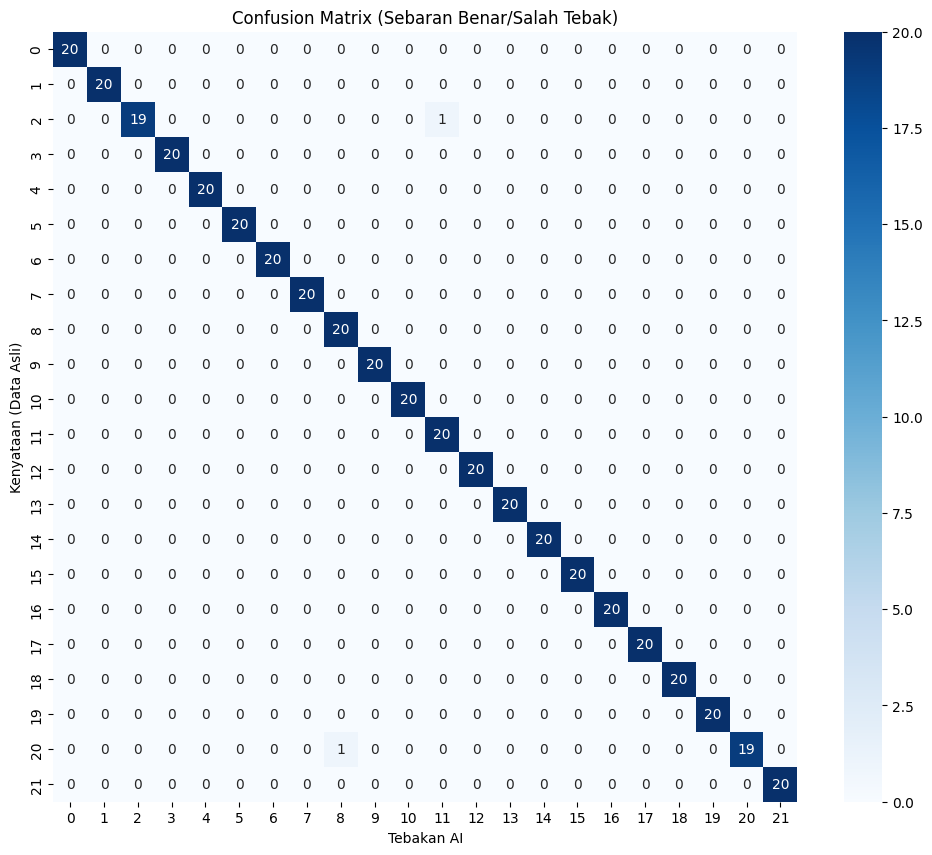

<Figure size 640x480 with 0 Axes>

In [8]:
print("\n--- Evaluasi Model ---")
y_pred = best_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)
mlflow.log_text(report, "classification_report.txt")

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sebaran Benar/Salah Tebak)")
plt.xlabel("Tebakan AI")
plt.ylabel("Kenyataan (Data Asli)")
plt.show()
mlflow.log_figure(plt.gcf(), "confusion_matrix.png")

## Import Model

In [9]:
if best_model:
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"\nModel terbaik ({best_model_name}) disimpan ke {MODEL_PATH}")


Model terbaik (RandomForest) disimpan ke crop_model_pipeline.pkl
